## Preface



In [1]:
import cfe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

r = cfe.result.from_dataset('Indian ICRISAT_small.ds',engine='netcdf4')
UseNutrients=['Protein','Calories','Iron']

# Reference period, market
t,m = 75,1

# Reference budget (find mean in reference period & market):
reference_x = r.get_predicted_expenditures().mean('j').sum('i').sel(t=t,m=m)

p = r.prices.sel(t=t,m=m,drop=True)
p = p.to_dataframe('i').squeeze().dropna()
p

/home/ligon/anaconda3/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


i
Bengalgram Dhal           7.025319
Brinjal                   0.845954
Ceremonial expenses    1150.546276
Chillies                  3.023207
Greengram (Mung)          2.671608
Gur (Jaggery)             2.585754
Jowar/Sorghum             1.521374
Milk                      4.140857
Onion                     1.487030
Other Dhal                6.599156
Other Spices              3.829967
Pan, Betel, etc.         27.440280
Redgram Dhal              8.348026
Rice                      3.945993
Sugar                     2.744875
Tea                      14.918429
Tomato                    0.493349
Wheat                     2.298911
Name: i, dtype: float64

## Nutritional requirements



Individuals have nutritional requirements established by nutrition
scientists.  Here are some standards established by the Indian
National Institute of Nutrition:



### Nutritional Needs of individuals



#### Recommended Daily Allowances: India



| Sex-Age|Calories|Protein|Fat|Calcium|Iron|Betacarotene|Thiamine|Riboflavin|Niacin|Ascorbic Acid|
|---|---|---|---|---|---|---|---|---|---|---|
| C 0-0.5||||500|||.2|.3||25|
| C 0.5-1|||19|500|5|2800|.3|.4||25|
| C 1-3|1060|16.7|27|600|9|3200|.5|.6|8|40|
| C 4-6|1350|20.1|25|600|13|3200|.7|.8|11|40|
| C 7-9|1690|29.5|30|600|16|4800|.8|1.|13|40|
| B 10-12|2190|39.9|35|800|21|4800|1.1|1.3|15|40|
| G 10-12|2010|40.4|35|800|27|4800|1.|1.2|13|40|
| B 13-15|2750|54.3|45|800|32|4800|1.4|1.6|16|40|
| G 13-15|2330|51.9|40|800|27|4800|1.2|1.4|14|40|
| B 16-17|3020|61.5|50|800|28|4800|1.5|1.8|17|40|
| G 16-17|2440|55.5|35|800|26|4800|1.|1.2|14|40|
| M|2730|60|30|600|17|4800|1.4|1.4|18|40|
| W|2230|55|25|1200|21|4800|1.1|1.3|14|40|



### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in the ICRISAT villages, the number of
different kinds of people can be computed by averaging over households:



In [2]:
# In first round, averaged over households and villages

zbar = r.z.sel(t=r.firstround,drop=True).mean(['j','m'])[:-1].squeeze() # Leave out log HSize

zbar = zbar.to_dataframe().squeeze()

Now, the inner/dot/matrix product between `zbar` and the `rda`
DataFrame of requirements will give us minimum requirements for the
average household:



In [3]:
rda = pd.read_pickle('indian_rda.df').T

# May need to tweak types or alignment to match RDA and zbar types:
rda0,zbar0=rda.align(zbar,axis=1)

# This matrix product gives minimum nutrient requirements for average
# household in 1975
hh_rda = rda0.replace('',0)@zbar0

# RDA is /daily/, but  demands in ICRISAT data are /annual/:
hh_rda = hh_rda*365

## Nutritional Adequacy of Food Demands



### Food Conversion Table



As usual, we need data to convert foods to nutrients:



In [4]:
from eep153_tools.sheets import read_sheets

DataURL = 'https://docs.google.com/spreadsheets/d/13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo'
key = DataURL.split('/')[-1]

fct = read_sheets(key,sheet='FCT').set_index('i')

Key available for students@eep153.iam.gserviceaccount.com.
Key available for instructors@eep153.iam.gserviceaccount.com.


### Prices



In [5]:
def my_prices(p0,p=p,i='Coconut'):
    p = p.copy()
    p.loc[i] = p0
    return p

### Nutrient Demand



We can also use our demand functions to
 compute nutrition as a *function* of prices and budget.



In [6]:
import warnings 

def nutrient_demand(x,p):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        c = r.demands(x,p)

    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



Text(0, 0.5, 'log nutrient')

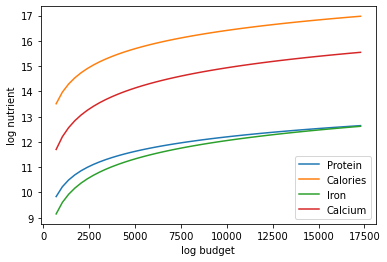

In [7]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(reference_x/5,reference_x*5,50)

UseNutrients = ['Protein','Calories','Iron','Calcium']

df = pd.concat({myx:np.log(nutrient_demand(myx,p))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Now how does nutrition vary with prices?



Text(0, 0.5, 'log nutrient')

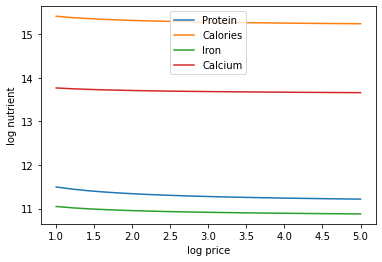

In [12]:
USE_GOOD = 'Wheat'

ref_price = r.prices.sel(i=USE_GOOD,t=t,m=m,drop=True)

P = np.linspace(1,5,20).tolist()

ndf = pd.DataFrame({p0:np.log(nutrient_demand(reference_x,my_prices(p0,i=USE_GOOD)))[UseNutrients] for p0 in P}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

### Nutritional Adequacy



Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet.



In [9]:
def nutrient_adequacy_ratio(x,p):
    return nutrient_demand(x,p)/hh_rda

In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.



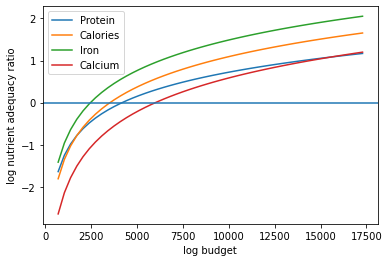

In [13]:
X = np.linspace(reference_x/5,reference_x*5,50)

ndf = pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T

ax = ndf.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient adequacy ratio')
ax.axhline(0)

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:



In [ ]:
poorer_x = reference_x/2

Pscale = np.linspace(1,3,20).tolist()

log_nar = {s0:np.log(nutrient_adequacy_ratio(reference_x,my_prices(s0,p,i=USE_GOOD)))[UseNutrients] for s0 in Pscale}

log_nar = pd.DataFrame(log_nar).T

ax = log_nar.plot(ylabel='log NAR',xlabel='Price')


ax.axhline(0)
ax.axvline(p[USE_GOOD])